1. Gibson-Lanni PSF simulator, using Kyle Douglass [implementation](http://kmdouglass.github.io/posts/implementing-a-fast-gibson-lanni-psf-solver-in-python.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import scipy.special
from scipy.interpolate import interp1d
from matplotlib import animation

In [8]:
# Image properties
# Size of the PSF array, pixels
size_x = 256
size_y = 256
size_z = 128

# Precision control
num_basis    = 100  # Number of rescaled Bessels that approximate the phase function
num_samples  = 1000 # Number of pupil samples along radial direction
oversampling = 2    # Defines the upsampling ratio on the image space grid for computations

# Microscope parameters
NA          = 0.8
wavelength  = 0.525 # microns
M           = 40   # magnification
ns          = 1.33  # specimen refractive index (RI)
ng0         = 1.5   # coverslip RI design value. 
ng          = 1.5   # coverslip RI experimental value
ni0         = 1.33   # immersion medium RI design value
ni          = 1.33   # immersion medium RI experimental value
ti0         = 3500 - 170   # microns, working distance (immersion medium thickness) design value
tg0         = 170   # microns, coverslip thickness design value
tg          = 170   # microns, coverslip thickness experimental value
res_lateral = 6.5/M   # microns
res_axial   = 0.25  # microns
pZ          = 0.5     # microns, particle distance from coverslip

# Scaling factors for the Fourier-Bessel series expansion
min_wavelength = 0.436 # microns
scaling_factor = NA * (3 * np.arange(1, num_basis + 1) - 2) * min_wavelength / wavelength

In [9]:
# Place the origin at the center of the final PSF array
x0 = (size_x - 1) / 2
y0 = (size_y - 1) / 2

# Find the maximum possible radius coordinate of the PSF array by finding the distance
# from the center of the array to a corner
max_radius = round(np.sqrt((size_x - x0) * (size_x - x0) + (size_y - y0) * (size_y - y0))) + 1;

# Radial coordinates, image space
r = res_lateral * np.arange(0, oversampling * max_radius) / oversampling

# Radial coordinates, pupil space
a = min([NA, ns, ni, ni0, ng, ng0]) / NA
rho = np.linspace(0, a, num_samples)

# Stage displacements away from best focus
z = res_axial * np.arange(-size_z / 2, size_z /2) + res_axial / 2

In [10]:
# Define the wavefront aberration
OPDs = pZ * np.sqrt(ns * ns - NA * NA * rho * rho) # OPD in the sample
OPDi = (z.reshape(-1,1) + ti0) * np.sqrt(ni * ni - NA * NA * rho * rho) - ti0 * np.sqrt(ni0 * ni0 - NA * NA * rho * rho) # OPD in the immersion medium
OPDg = tg * np.sqrt(ng * ng - NA * NA * rho * rho) - tg0 * np.sqrt(ng0 * ng0 - NA * NA * rho * rho) # OPD in the coverslip
W    = 2 * np.pi / wavelength * (OPDs + OPDi + OPDg)

# Sample the phase
# Shape is (number of z samples by number of rho samples)
phase = np.cos(W) + 1j * np.sin(W)

# Define the basis of Bessel functions
# Shape is (number of basis functions by number of rho samples)
J = scipy.special.jv(0, scaling_factor.reshape(-1, 1) * rho)

# Compute the approximation to the sampled pupil phase by finding the least squares
# solution to the complex coefficients of the Fourier-Bessel expansion.
# Shape of C is (number of basis functions by number of z samples).
# Note the matrix transposes to get the dimensions correct.
C, residuals, _, _ = np.linalg.lstsq(J.T, phase.T)

C:\Users\nvladim\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


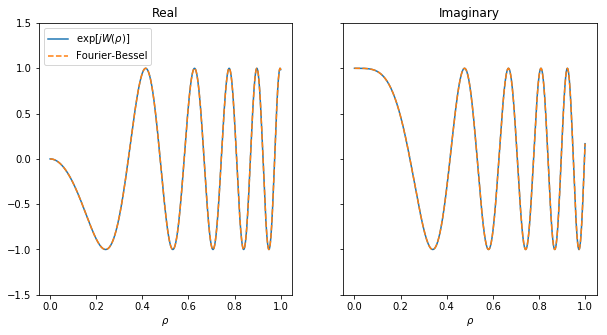

In [11]:
# Which z-plane to compute
z0 = 24

# The Fourier-Bessel approximation
est = J.T.dot(C[:,z0])

fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(10,5))
ax[0].plot(rho, np.real(phase[z0, :]), label=r'$ \exp{ \left[ jW \left( \rho \right) \right] }$')
ax[0].plot(rho, np.real(est), '--', label='Fourier-Bessel')
ax[0].set_xlabel(r'$\rho$')
ax[0].set_title('Real')
ax[0].legend(loc='upper left')

ax[1].plot(rho, np.imag(phase[z0, :]))
ax[1].plot(rho, np.imag(est), '--')
ax[1].set_xlabel(r'$\rho$')
ax[1].set_title('Imaginary')
ax[1].set_ylim((-1.5, 1.5))

plt.show()

In [12]:
b = 2 * np. pi * r.reshape(-1, 1) * NA / wavelength

# Convenience functions for J0 and J1 Bessel functions
J0 = lambda x: scipy.special.jv(0, x)
J1 = lambda x: scipy.special.jv(1, x)

# See equation 5 in Li, Xue, and Blu
denom = scaling_factor * scaling_factor - b * b
R = (scaling_factor * J1(scaling_factor * a) * J0(b * a) * a - b * J0(scaling_factor * a) * J1(b * a) * a)
R /= denom

In [13]:
# The transpose places the axial direction along the first dimension of the array, i.e. rows
# This is only for convenience.
PSF_rz = (np.abs(R.dot(C))**2).T

# Normalize to the maximum value
PSF_rz /= np.max(PSF_rz)

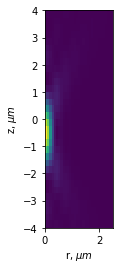

In [16]:
#Profile in R and Z
# z is the stage displacement in an inverted microscope. So, negative z's correspond to moving "up" in the sample.
fig, ax = plt.subplots()

ax.imshow(PSF_rz, extent=(r.min(), r.max(), z.max(), z.min()))
ax.set_xlim((0,2.5))
ax.set_ylim((-4, 4))
ax.set_xlabel(r'r, $\mu m$')
ax.set_ylabel(r'z, $\mu m$')

plt.show()

In [17]:
# Resample the PSF onto a rotationally-symmetric Cartesian grid
#Here we generate a two dimensional grid where the value at each grid point is the distance 
# of the point from the center of the grid. These values are supplied to an interpolation function 
# computed from PSF_rz to produce a rotationally-symmetric 2D PSF at each z-position.
# Create the fleshed-out xy grid of radial distances from the center
xy      = np.mgrid[0:size_y, 0:size_x]
r_pixel = np.sqrt((xy[1] - x0) * (xy[1] - x0) + (xy[0] - y0) * (xy[0] - y0)) * res_lateral

PSF = np.zeros((size_y, size_x, size_z))

for z_index in range(PSF.shape[2]):
    # Interpolate the radial PSF function
    PSF_interp = interp1d(r, PSF_rz[z_index, :])
    
    # Evaluate the PSF at each value of r_pixel
    PSF[:,:, z_index] = PSF_interp(r_pixel.ravel()).reshape(size_y, size_x)

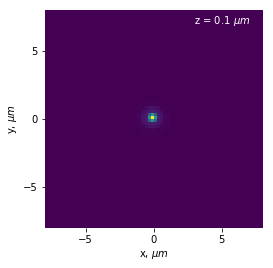

In [24]:
z_ind = 64
fig, ax    = plt.subplots(nrows=1, ncols=1)

# Rescale the PSF values logarithmically for better viewing
PSF_log = np.log(PSF)
#vmin, vmax = PSF_log.min(), PSF_log.max()

img = ax.imshow(PSF[:,:,z_ind])
img.set_extent([-r.max(), r.max(), -r.max(), r.max()])

txt = ax.text(3, 7, 'z = {:.1f} $\mu m$'.format(z[z_ind]),color='w')
ax.set_xlim((-8, 8))
ax.set_xticks((-5, 0, 5))
ax.set_xlabel(r'x, $\mu m$')
ax.set_ylim((-8, 8))
ax.set_yticks((-5, 0, 5))
ax.set_ylabel(r'y, $\mu m$')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)